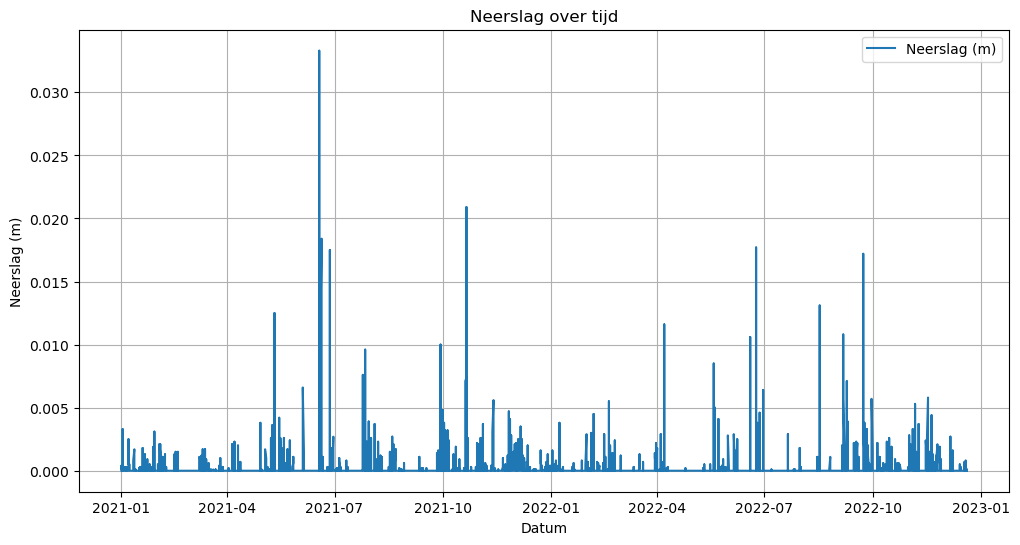

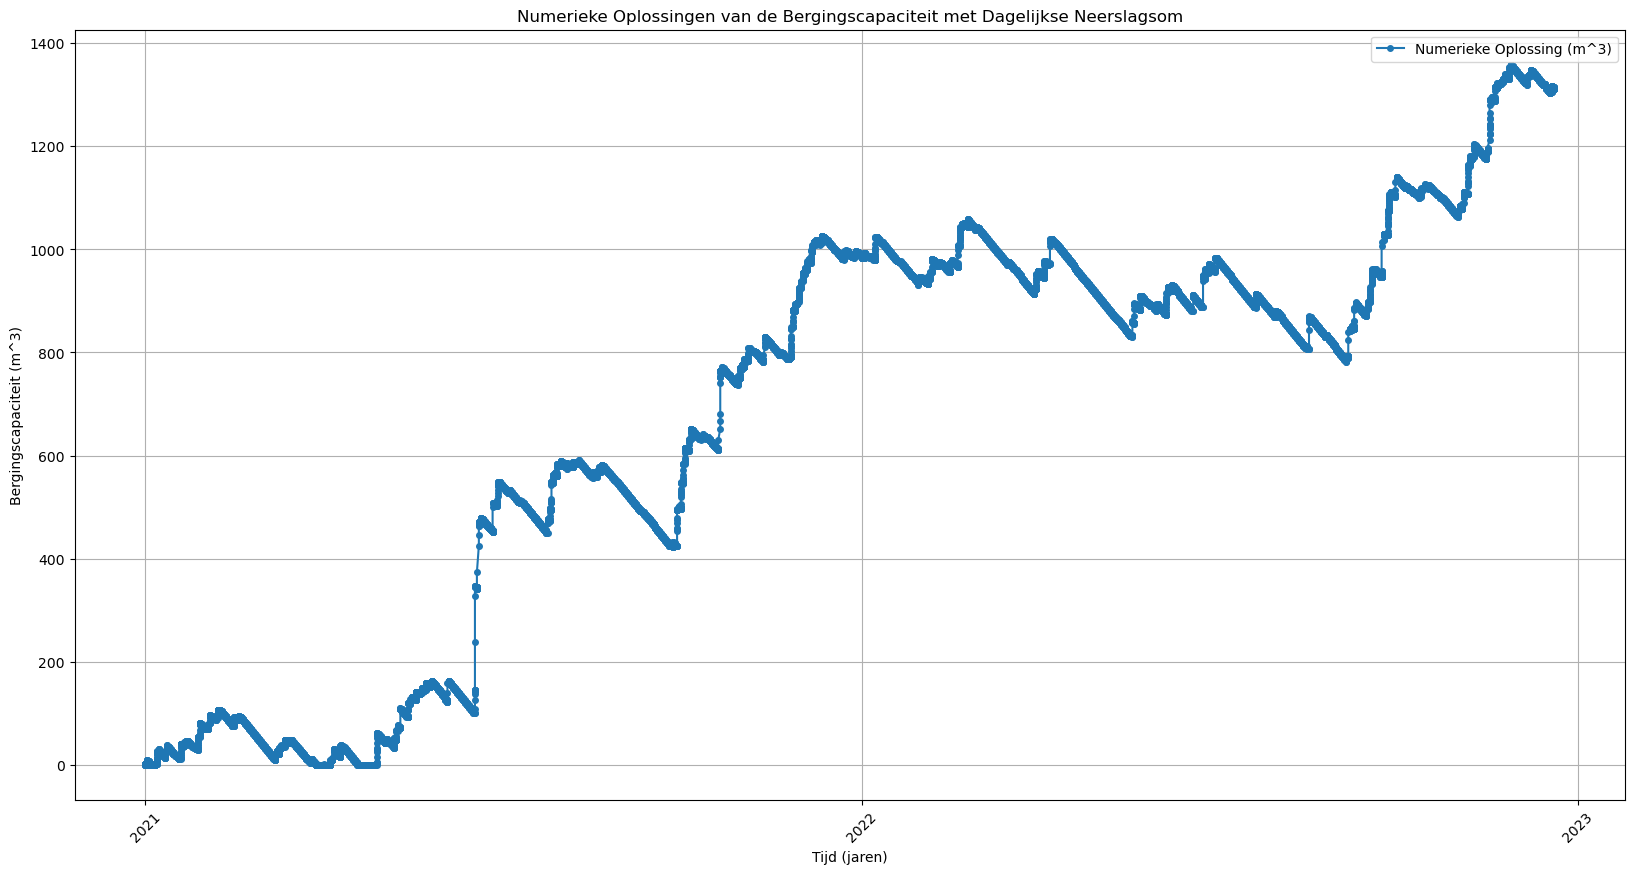

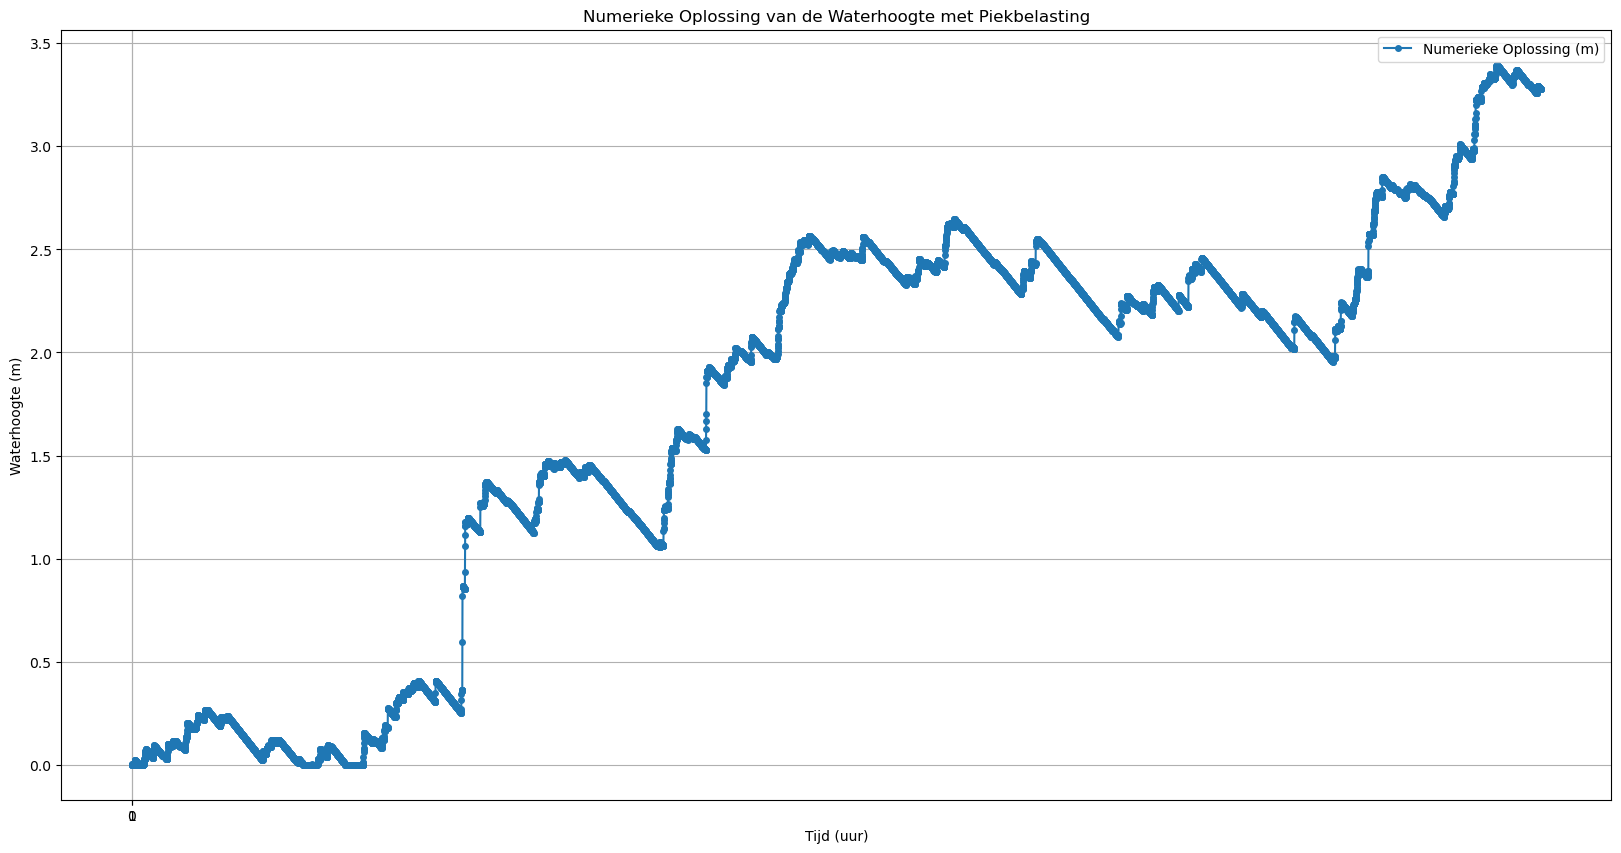

In [27]:
#Lijstje van de benodigde imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#Omzetten verkregen dataset KNMI naar lijst met gefilterde waardes

# Inladen van de KNMI dataset
input_file = 'KNMI neerslag Wijk aan Zee (2).txt'

#Inladen van de KNMI dataset waarbij de eerste 51 rijen worden verwijderd. Deze informatie is namelijk irrelevant.
#Wel behouden van de kolommen "YYYYMMDD" en "RH". Dit is namelijk relevante informatie 
df_neerslag = pd.read_csv('KNMI neerslag Wijk aan Zee (2).txt', skiprows=8, 
                          skipinitialspace= True, header=0, usecols=["YYYYMMDD","RH"])

#format is voor notatie van de import
df_neerslag['DateTime'] = pd.to_datetime(df_neerslag['YYYYMMDD'].astype(str), format='%Y%m%d')

#Verwijderen NaN rijen
df_neerslag.dropna(inplace=True)

#Omzetten neerslag naar mm, daarna naar m
df_neerslag.RH = df_neerslag.RH * 0.1/1000

# Zet alle waarden kleiner dan 0 op 0
df_neerslag["RH"] = df_neerslag["RH"].apply(lambda x: max(0, x))

#RH waardes in een lijst zetten
Uursom_neerslag = df_neerslag['RH'].tolist()

# Plot de DateTime tegenover de RH
plt.figure(figsize=(12, 6))
plt.plot(df_neerslag["DateTime"], df_neerslag["RH"], label="Neerslag (m)")
plt.title("Neerslag over tijd")
plt.xlabel("Datum")
plt.ylabel("Neerslag (m)")
plt.grid(True)
plt.legend()
plt.show()



#Invoer van KNMI dataset in het model van de waterbergende weg

# Parameters
A_hellend_dak = 660.88
A_vlak_dak = 56.12
A_rijweg_goot = 836.99
A_trottoir_goot = 532.36
A_trottoir_kolk = 177.02 
A_parkeerplaatsen = 570.08

A_totaal= A_hellend_dak + A_vlak_dak + A_rijweg_goot + A_trottoir_goot + A_trottoir_kolk + A_parkeerplaatsen
A_rockflow = 1000   #Oppervlak van het bergend pakket (m^2)

k_bodem = 0.0002   #Doorlatendheidscoëfficiënt van de bodem (m/uur)
k_rockflow = 200/24 #Doorlatendheidscoëfficiënt van de rockflow (m/uur)
por_bodem = 0.4
por_rockflow = 0.95
t0 = 0

uren = len(Uursom_neerslag)

# Tijdstappen en initiële conditie
dt = 1  # Tijdstap (uren)
t = np.arange(0, uren, dt)  # Tijdstappen van 0 tot 24 uur
V = np.zeros(len(t))  # Array voor de bergingscapaciteit
h = np.zeros(len(t))  # Array voor de waterhoogte in het infiltratiepakket

# Initiële conditie
V[0] = 0.0  # Initiële bergingscapaciteit (m^3)

# Numerieke oplossing met behulp van de methode van Euler
for i in range(1, len(t)):
    dVdt = (Uursom_neerslag[i] * A_totaal - k_bodem * A_rockflow)
    V[i] = max(0, V[i - 1] + dVdt * dt)
    h[i] = max(0, V[i] / por_bodem / A_rockflow)

# Plot de numerieke oplossing voor het volume (verbeterde x-as)
plt.figure(figsize=(20, 10))
plt.plot(df_neerslag["DateTime"], V, label='Numerieke Oplossing (m^3)', marker='o', markersize=4, linestyle='-')
plt.xlabel('Tijd (jaren)')  # Verander x-as label naar 'Tijd (jaren)'
plt.ylabel('Bergingscapaciteit (m^3)')
plt.title('Numerieke Oplossingen van de Bergingscapaciteit met Dagelijkse Neerslagsom')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=1))  # Alleen de jaren laten zien
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)  # Roteren van de waardes op de x-as
plt.show()

# Plot de numerieke oplossing voor waterhoogte
plt.figure(figsize=(20, 10))
plt.plot(t, h, label='Numerieke Oplossing (m)', marker='o', markersize=4, linestyle='-')
plt.xlabel('Tijd (uur)')
plt.ylabel('Waterhoogte (m)')
plt.title('Numerieke Oplossing van de Waterhoogte met Piekbelasting')
plt.legend()
plt.grid(True)
plt.xticks(np.arange(0, 2, 1))  # Tijdstapmarkeringen om de 1 dag
plt.show()

,object_id,description,well_covering_project_code,result_timestamp,water_level,water_level_unit,DateTime
0,5361029,PB1.03 (Rockflow),215231,26-6-2021 15:59,-1.102,m (NAP),2021-06-26 15:59:00
1,5361029,PB1.03 (Rockflow),215231,26-6-2021 16:59,-1.069,m (NAP),2021-06-26 16:59:00
2,5361029,PB1.03 (Rockflow),215231,26-6-2021 17:59,-1.056,m (NAP),2021-06-26 17:59:00
3,5361029,PB1.03 (Rockflow),215231,26-6-2021 18:59,-1.056,m (NAP),2021-06-26 18:59:00
4,5361029,PB1.03 (Rockflow),215231,26-6-2021 19:59,-1.051,m (NAP),2021-06-26 19:59:00
...,...,...,...,...,...,...,...
6427,5361029,PB1.03 (Rockflow),215231,22-11-2023 05:00,-1.068,m (NAP),2023-11-22 05:00:00
6428,5361029,PB1.03 (Rockflow),215231,22-11-2023 06:00,-1.076,m (NAP),2023-11-22 06:00:00
6429,5361029,PB1.03 (Rockflow),215231,22-11-2023 07:00,-1.073,m (NAP),2023-11-22 07:00:00
6430,5361029,PB1.03 (Rockflow),215231,22-11-2023 08:00,-1.072,m (NAP),2023-11-22 08:00:00


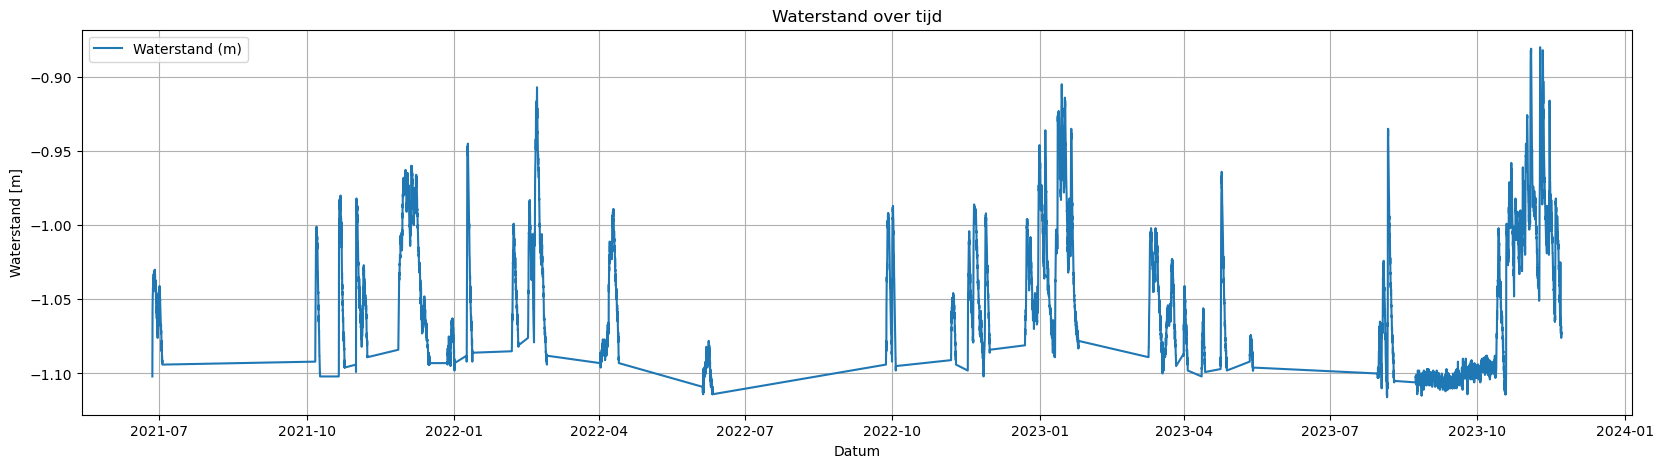

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Lees CSV-bestand in met puntkomma als scheidingsteken
df_PB03 = pd.read_csv('PB03_01122020_01122023.csv', skipinitialspace=True, header=0, sep=';')
# Maak een datum kolom
df_PB03['DateTime'] = pd.to_datetime(df_PB03['result_timestamp'], format='%d-%m-%Y %H:%M')

# Toon de kolomnamen
#print(df_PB03.columns)
display(df_PB03)
#df_PB03.head(20)

#plot de DateTime tegenover het water_level
plt.figure(figsize=(20, 5))
plt.plot(df_PB03["DateTime"], df_PB03["water_level"], label="Waterstand (m)")
plt.title("Waterstand over tijd")
plt.xlabel("Datum")
plt.ylabel("Waterstand [m]")
plt.grid(True)
plt.legend()
plt.show()

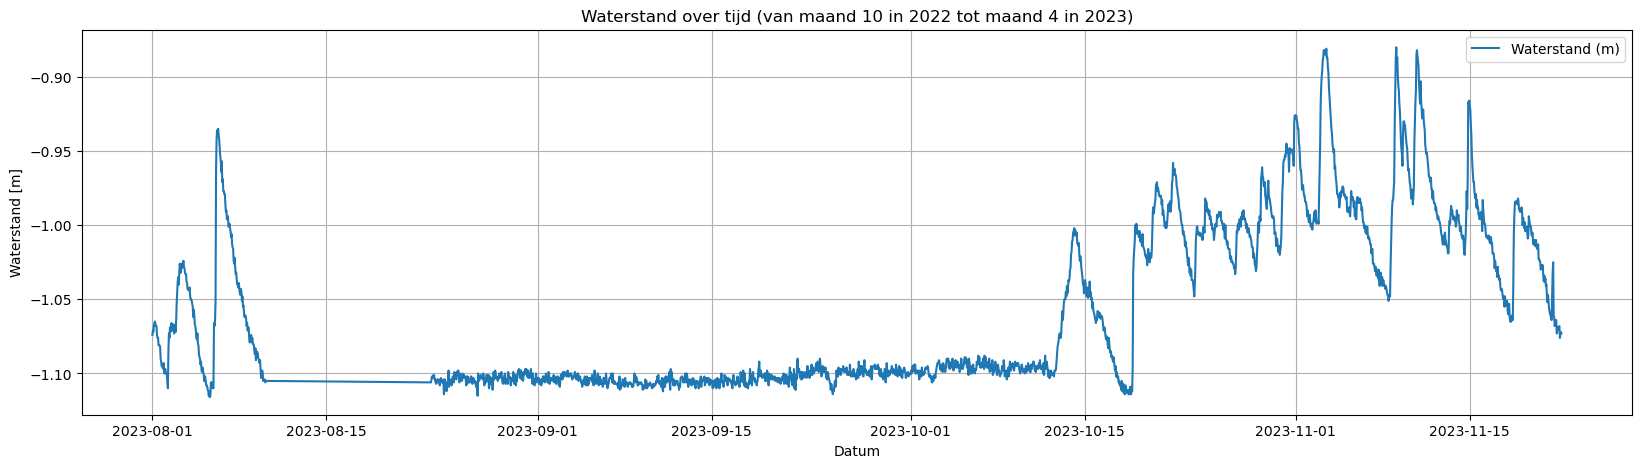

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Lees CSV-bestand in met puntkomma als scheidingsteken
df_PB03 = pd.read_csv('PB03_01122020_01122023.csv', skipinitialspace=True, header=0, sep=';')

# Maak een datum kolom
df_PB03['DateTime'] = pd.to_datetime(df_PB03['result_timestamp'], format='%d-%m-%Y %H:%M')

# Filter het DataFrame op het gewenste tijdsinterval (van maand 10 in 2022 tot maand 4 in 2023)
start_date = pd.to_datetime('2023-08-01')
end_date = pd.to_datetime('2023-11-30')
df_filtered = df_PB03[(df_PB03['DateTime'] >= start_date) & (df_PB03['DateTime'] <= end_date)]

# Plot de DateTime tegenover het water_level
plt.figure(figsize=(20, 5))
plt.plot(df_filtered["DateTime"], df_filtered["water_level"], label="Waterstand (m)")
plt.title("Waterstand over tijd (van maand 10 in 2022 tot maand 4 in 2023)")
plt.xlabel("Datum")
plt.ylabel("Waterstand [m]")
plt.grid(True)
plt.legend()
plt.show()

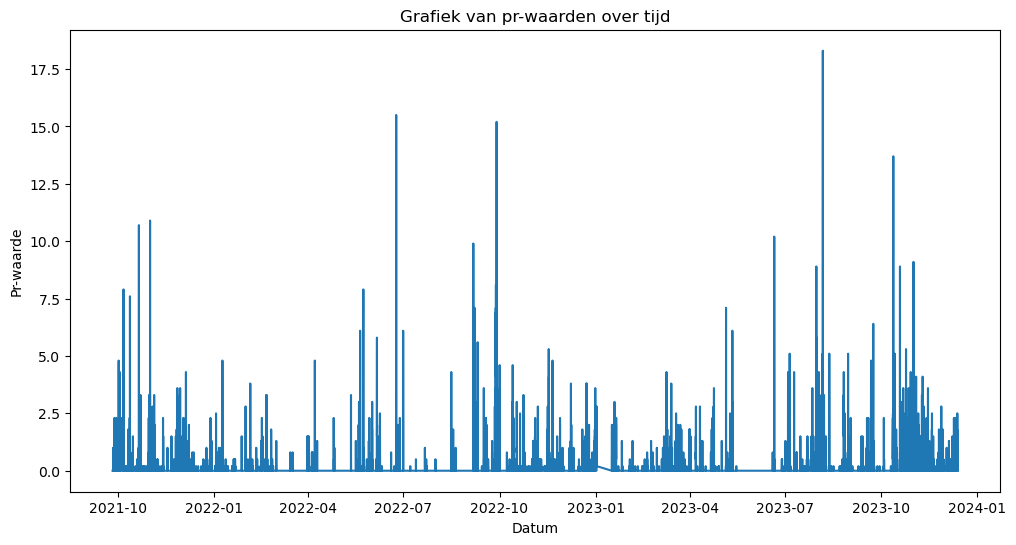

In [30]:
# Wijzig de werkdirectory
os.chdir('C:\\Users\\Gebruiker\\Documents\\Programmeren\\Casus_waterbergende_weg\\')

# Bestandsnaam
origineel_bestand = 'pr_tg_Hoogmade_id7dffd7e2-25e0-e711-9405-0003ff59b2bd.csv'

# Lees de originele gegevens in
data = pd.read_csv(origineel_bestand, delimiter= ';')

# Haal de kolomnamen op
var = list(data.columns)

# Controleer en converteer de 'pr'-kolom naar numerieke waarden
data[var[2]] = pd.to_numeric(data[var[2]], errors='coerce')

# Vervang NaN-waarden door 0.0 in de 'pr'-kolom
data[var[2]].fillna(0.0, inplace=True)

# Converteer de 'pr'-kolom naar een lijst
aangepaste_data_list = data[var[2]].tolist()

# Haal de gegevens op voor de plot
pr = data[var[2]]
tt = pd.to_datetime(data["datum"])

# Maak een nieuw figuur met aangepaste grootte
plt.figure(figsize=(12, 6))

# Plot de gegevens
plt.plot(tt, pr)

# Voeg labels toe aan de assen en een titel
plt.xlabel('Datum')
plt.ylabel('Pr-waarde')
plt.title('Grafiek van pr-waarden over tijd')

# Toon de plot
plt.show()

# Geef de lijst van aangepaste gegevens weer
#print("Aangepaste gegevens als lijst:")
#print(aangepaste_data_list)
